# Hotdog Classifier

Opsætning af FastAI

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
# Azure API Key
key = os.environ.get('AZURE_SEARCH_KEY', '88f816fb74d147e08b211baf0cceebbb')

In [ ]:
bear_types = 'hotdog', 'random'
path = Path('hotdogs')

In [ ]:
# Looper over de specificerede typer og søger på dem hver især
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
# Tjekker om der er billeder som er failed 
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#0) []

In [ ]:
# Fjerner billeder som er failed
failed.map(Path.unlink);

In [ ]:
# Laver DataLoaders for datasettet vi lige har downloaded udfra følgende:
# What kinds of data we are working with
# How to get the list of items
# How to label these items
# How to create the validation set

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
# Fortæller FastAI hvor kilden af dataen kan findes
dls = bears.dataloaders(path)

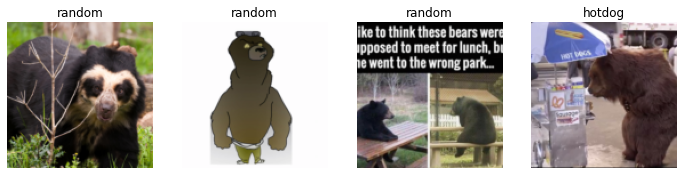

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

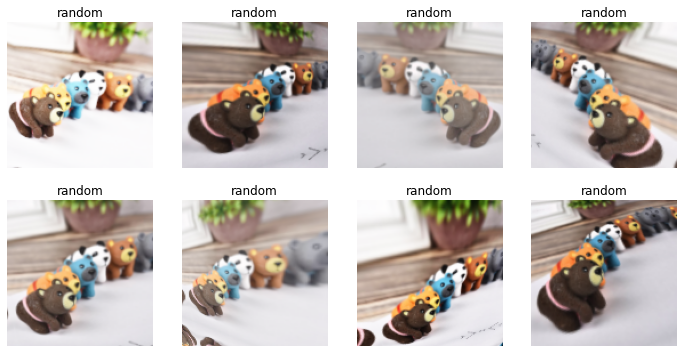

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.390173,1.273094,0.367347,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.905061,0.972034,0.285714,00:26
1,0.752968,0.839549,0.244898,00:26
2,0.642576,0.741575,0.183673,00:26
3,0.595402,0.717191,0.204082,00:25


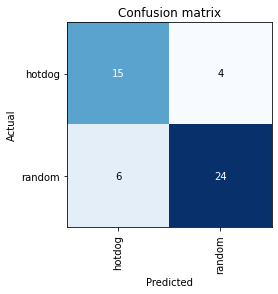

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

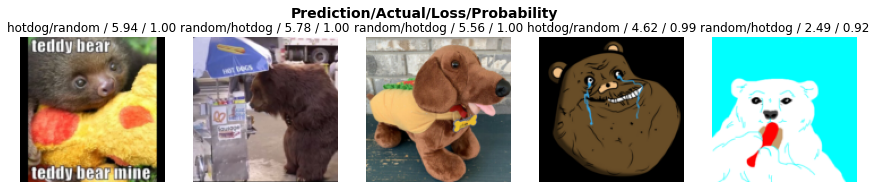

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
learn.export()

path = Path()
path.ls(file_exts='.pkl')

learn_inf = load_learner(path/'export.pkl')

learn_inf.dls.vocab